In [1]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlrose_hiive
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, ShuffleSplit, GridSearchCV, RandomizedSearchCV, train_test_split, learning_curve, ShuffleSplit

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import time
from scipy import linalg
import matplotlib as mpl
import itertools

import matplotlib.cm as cm

from sklearn.utils import shuffle
from sklearn.utils import check_random_state
from sklearn.cluster import MiniBatchKMeans

## utilities

In [19]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]


def generate_silhoutte_score_plot(X, k, model):
    n_clusters=np.arange(2, k)
    sils=[]
    sils_err=[]
    iterations=k
    for n in n_clusters:
        tmp_sil=[]
        for _ in range(iterations):
            clf=model(n).fit(X) 
            labels=clf.predict(X)
            sil=metrics.silhouette_score(X, labels, metric='euclidean')
            tmp_sil.append(sil)
        val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
        err=np.std(tmp_sil)
        sils.append(val)
        sils_err.append(err)
    plt.errorbar(n_clusters, sils, yerr=sils_err)
    plt.title("Silhouette Scores", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("N. of clusters ({})".format("Test"))
    plt.ylabel("Score")

## load data

In [4]:
full_data = pd.read_csv('faults.csv')

In [5]:
#change text to numercal
full_data['target'] = pd.Categorical(full_data['target']).codes

In [6]:
full_data.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,target
0,42,50.0,270900,270944,267,17,44,24220,76,108,...,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,4
1,645,651.0,2538079,2538108,108,10,30,11397,84,123,...,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,4
2,829,835.0,1553913,1553931,71,8,19,7972,99,125,...,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,4
3,853,860.0,369370,369415,176,13,45,18996,99,126,...,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,4
4,1289,1306.0,498078,498335,2409,60,260,246930,37,126,...,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,4


In [7]:
full_data.isnull().values.any()
full_data2=full_data.dropna(axis=0)

In [8]:
X = full_data2.iloc[:, 0:27]
Y = full_data2.iloc[:, -1]

In [9]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [10]:
X_scaled.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,-1.000154,-1.129207,-0.786509,-0.786510,-0.320389,-0.318791,-0.093004,-0.361790,-0.264111,-1.189754,...,-0.494459,-0.585382,0.810313,0.891761,-0.095768,-0.910582,0.524268,1.495888,-1.084334,-0.019607
1,0.174172,0.096547,0.489628,0.489610,-0.350667,-0.341645,-0.125251,-0.386436,-0.016588,-0.391450,...,-0.512836,-0.053415,0.668803,0.891761,-0.589524,-1.167575,0.126336,1.445449,-0.307396,-0.853562
2,0.532508,0.471820,-0.064334,-0.064354,-0.357713,-0.348174,-0.150589,-0.393019,0.447519,-0.285009,...,-0.511165,0.563240,0.586786,0.891761,-0.818251,-1.167575,-0.328727,1.191447,0.047162,-1.098635
3,0.579247,0.522808,-0.731083,-0.731083,-0.337718,-0.331850,-0.090701,-0.371831,0.447519,-0.231789,...,-0.486106,-0.306243,0.810313,0.891761,-0.323114,-1.029922,0.545582,1.548537,-0.181152,-0.198857
4,1.428346,1.432436,-0.658637,-0.658518,0.087515,-0.178401,0.404526,0.066274,-1.470790,-0.231789,...,-0.362483,-1.355379,0.761443,0.891761,1.104142,-0.236928,2.208284,1.728187,-0.465872,1.208112


## KMeans

In [11]:
from sklearn.cluster import KMeans

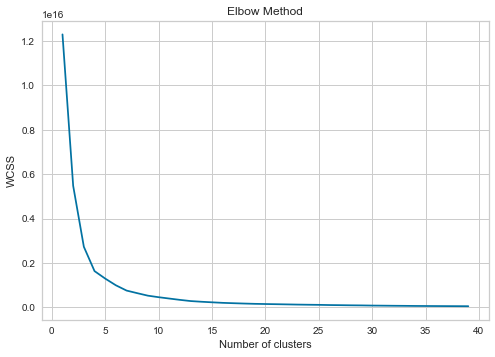

In [12]:
wcss = []
for i in range(1, 40):
    kmeans = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 40), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [14]:
# The number of iterations required to converge
kmeans.n_iter_

12

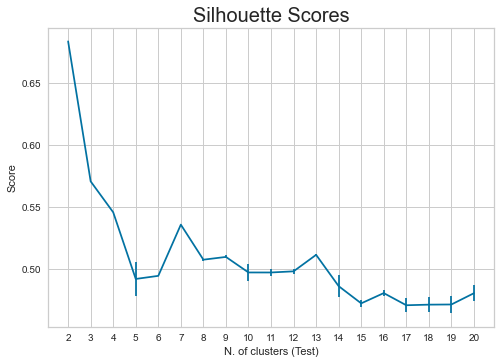

In [20]:
generate_silhoutte_score_plot(X, 21, KMeans)

In [21]:
from sklearn.metrics import silhouette_samples, silhouette_score

For n_clusters = 7 The average silhouette_score is : 0.5357362099081291


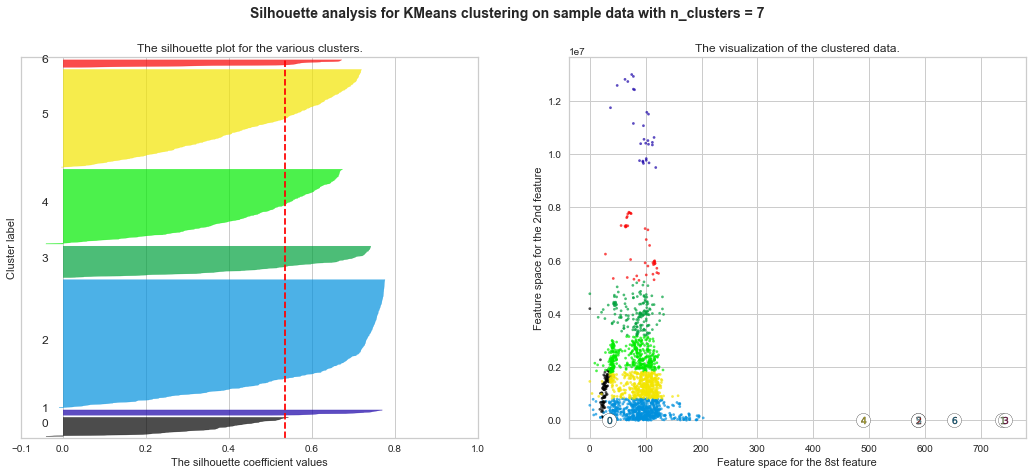

In [22]:
range_n_clusters = [ 7 ]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X.iloc[:, 8], X.iloc[:, 2], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 8st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [23]:
clusterNum = 7
k_means =KMeans(n_clusters=clusterNum, max_iter=300, n_init=10, random_state=0)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[1 4 3 ... 1 1 1]


In [24]:
from sklearn.metrics.cluster import rand_score
rand_score(Y, labels)

0.654982739914049

## EM

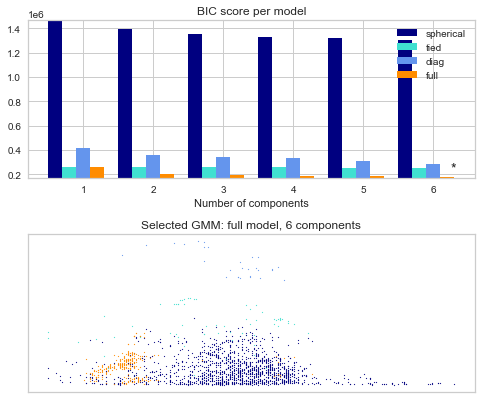

In [25]:
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_, color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X.iloc[Y_ == i, 8], X.iloc[Y_ == i, 2], 0.8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[10], v[11], 180.0 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)
plt.subplots_adjust(hspace=0.35, bottom=0.02)
plt.show()

In [26]:
clf

GaussianMixture(n_components=6)

In [27]:
from sklearn.metrics.cluster import rand_score
rand_score(Y, best_gmm.predict(X))

0.6180663204338107